- TensorFlow Hub is a way to share pretrained model components. See the TensorFlow Module Hub for a searchable listing of pre-trained models.

- This tutorial demonstrates:

    1. How to user TensorFlow Hub with `tf.keras`.
    2. How to do image classification using TensorFlow Hub.
    3. How to do simple transfer learning.

## Setup

### Imports

In [ ]:
!pip install -q tensorflow_hub

In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0328 10:07:10.816588 140710638126912 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.12.0'

#### Dataset

- For this example we'll use the TensorFlow flowers dataset:

In [2]:
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)

228818944/228813984 [==============================] - 29s 0us/step


- The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

- All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

- The image size will be handles later.

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


- The resulting object is an iterator that returns `image_batch`, `label_batch` pairs.

In [4]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32, 5)


## An ImageNet classifier

### Download the classifier

- Use `hub.module` to load a mobilenet, and `tf.keras.layers.Lambda` to wrap it up as a keras layer.

- Any [image classifier url from tfhub.dev](https://tfhub.dev/s?module-type=image-classification) will work here.

In [5]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [6]:
def classifier(x):
    classifier_module = hub.Module(classifier_url)
    return classifier_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [7]:
IMAGE_SIZE

[224, 224]

In [8]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 10:15:59.247847 140710638126912 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


- Rebuild the data generator, with the output size set to match what's expected by the module.

In [9]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


- When using Keras, TFHub modules need to be manually initialized.

In [10]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

### Run it on a single image

- Download a single image to try the model on.

65536/61306 [================================] - 0s 1us/step


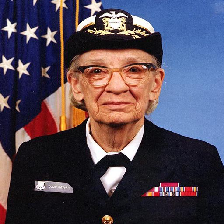

In [12]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper

In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

- Add a batch dimension, and pass the image to the model.

In [14]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

- The result is a 1001 element vector of logits, rating the probability of each class for the image.

- So the top class ID can be found with `argmax`:

In [15]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### Decode the predictions

- We have the predicted class ID, Fetch the `ImageNet` labels, and decode the predictions

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 1us/step


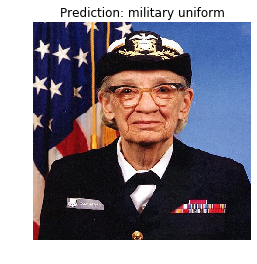

In [18]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

### Run it on a batch of images

- Now run the classifier on the image batch.

In [20]:
result_batch = classifier_model.predict(image_batch)

In [21]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['dining table', 'daisy', 'daisy', 'butcher shop', 'daisy', 'daisy',
       'daisy', 'bakery', 'daisy', 'bee', 'butcher shop', 'daisy',
       'barn spider', 'ant', 'cardoon', 'daisy', 'daisy', 'daisy',
       'lampshade', 'rapeseed', 'daisy', 'daisy', 'sea urchin', 'cardoon',
       'picket fence', 'dragonfly', 'cardoon', 'pot', 'vase', 'hip',
       'daisy', 'zucchini'], dtype='<U30')

- Now check how these predictions line up with the images:

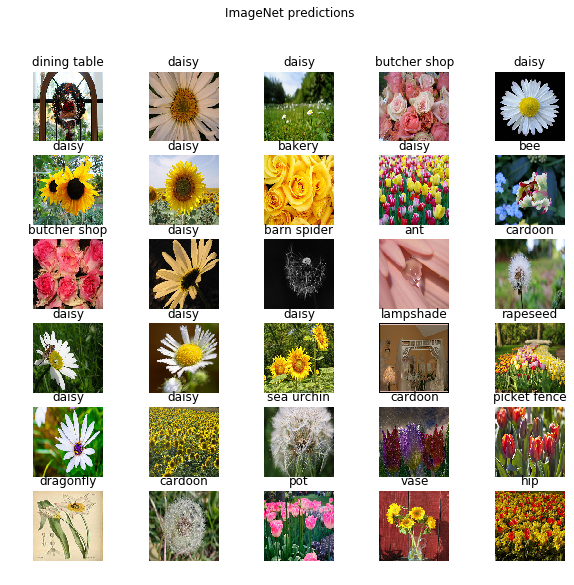

In [22]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
    
_ = plt.suptitle("ImageNet predictions")